In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
from sklearn.metrics import confusion_matrix
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [4]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

In [5]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [6]:
clinton_model = bmb.Model("vote['clinton'] ~ age", clinton_data, family="bernoulli")

In [7]:
clinton_fitted = clinton_model.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Modeling the probability that vote==clinton


Compiling...


Compilation time = 0:00:01.472930


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1542.81it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1544.28it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1545.68it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1547.15it/s]


Sampling time = 0:00:01.505552


Transforming variables...


Transformation time = 0:00:00.057659


Computing Log Likelihood...


Log Likelihood time = 0:00:00.170682


In [8]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, age]


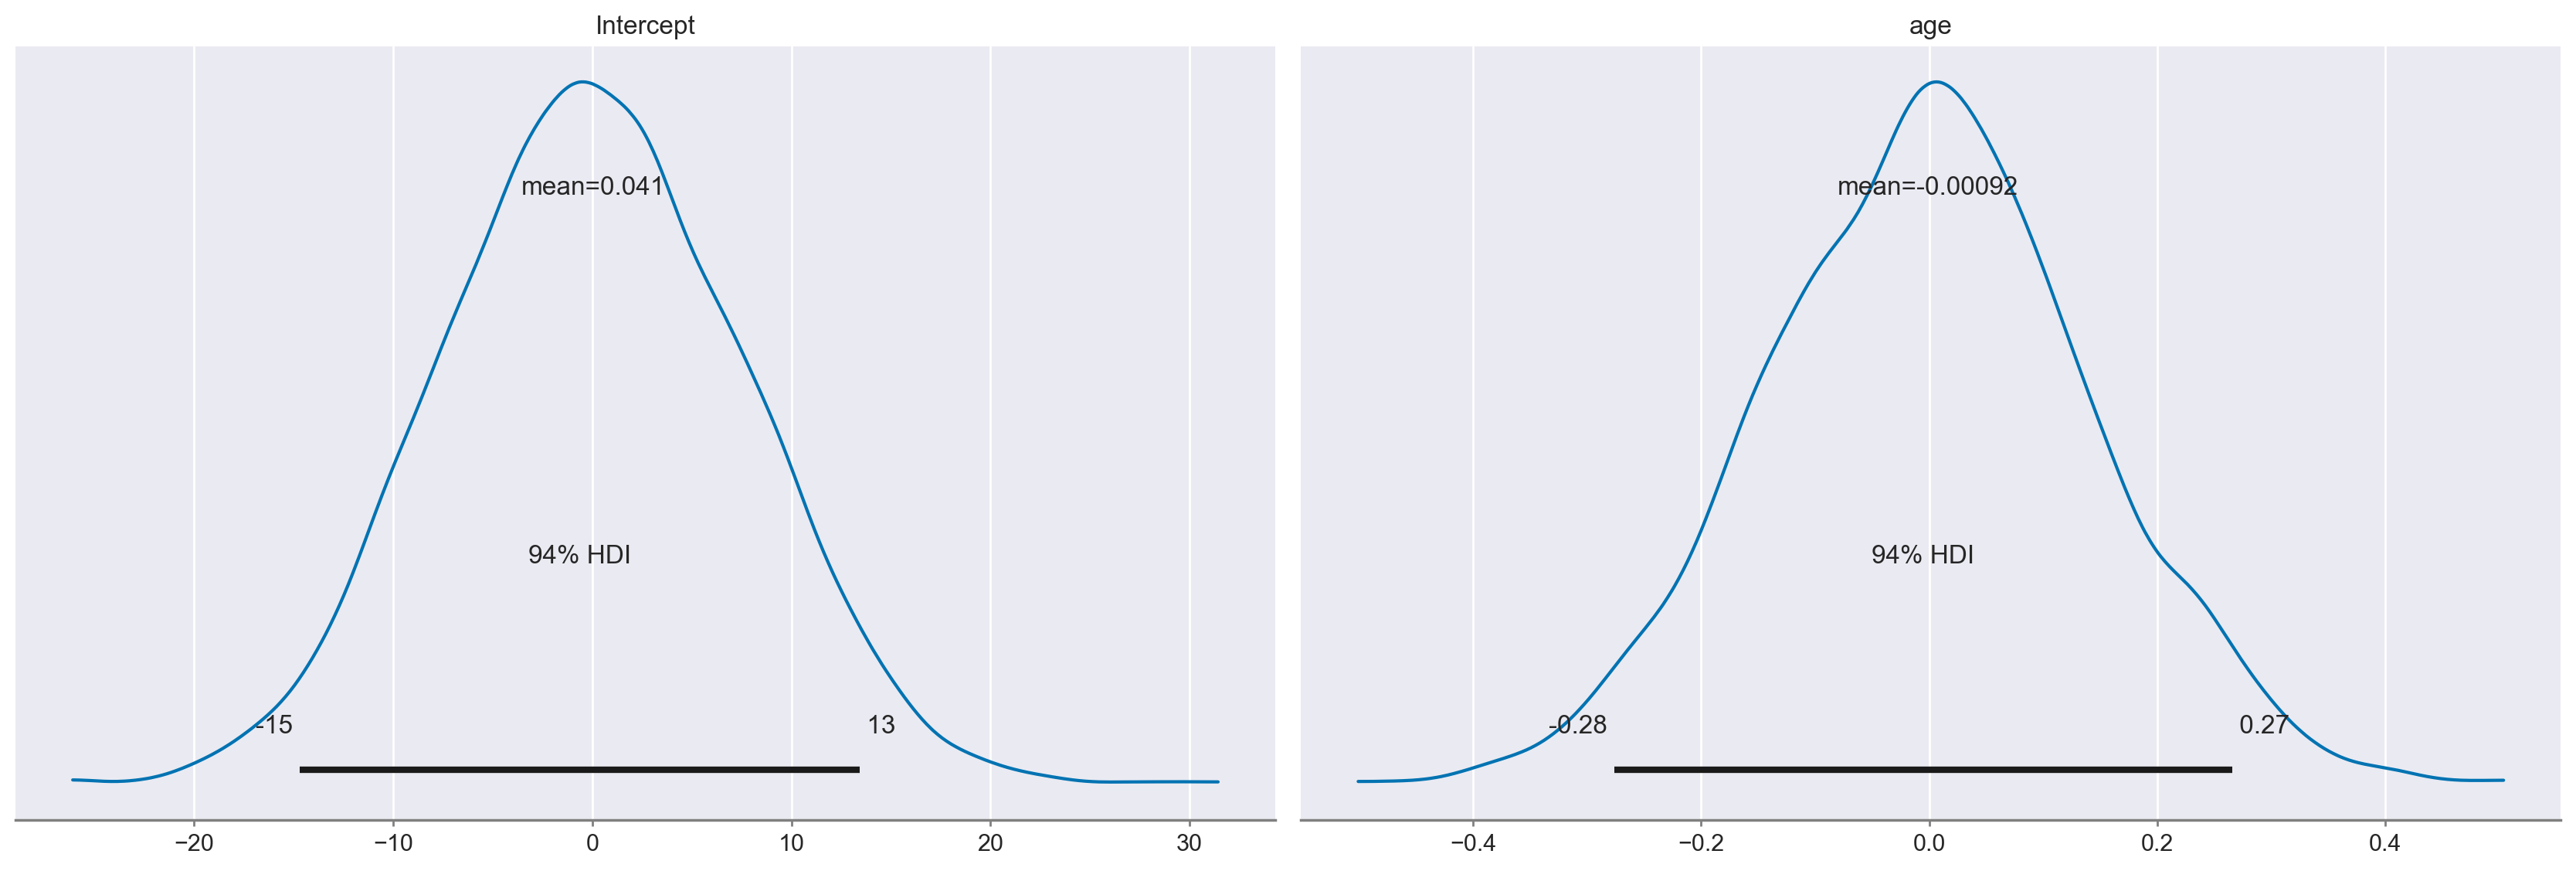

In [9]:
clinton_model.plot_priors()
plt.show()

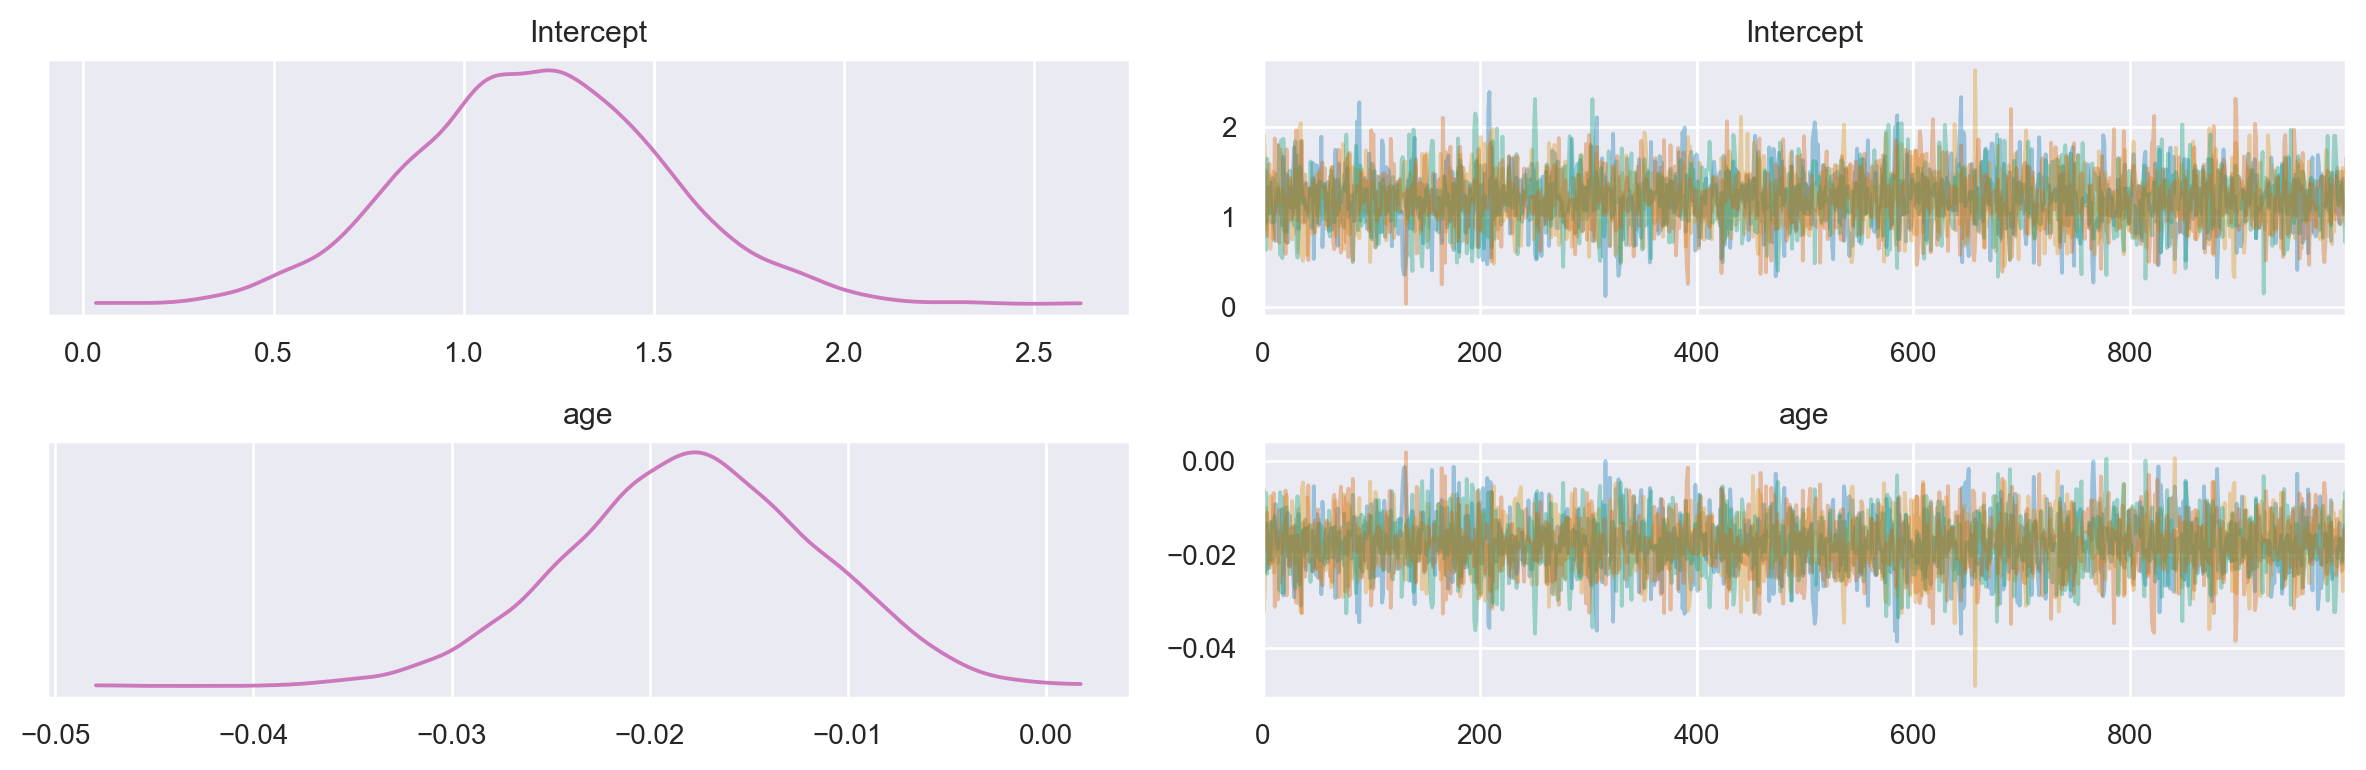

In [10]:
az.plot_trace(clinton_fitted, combined=True, compact=False)
plt.tight_layout()
plt.show()

In [11]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

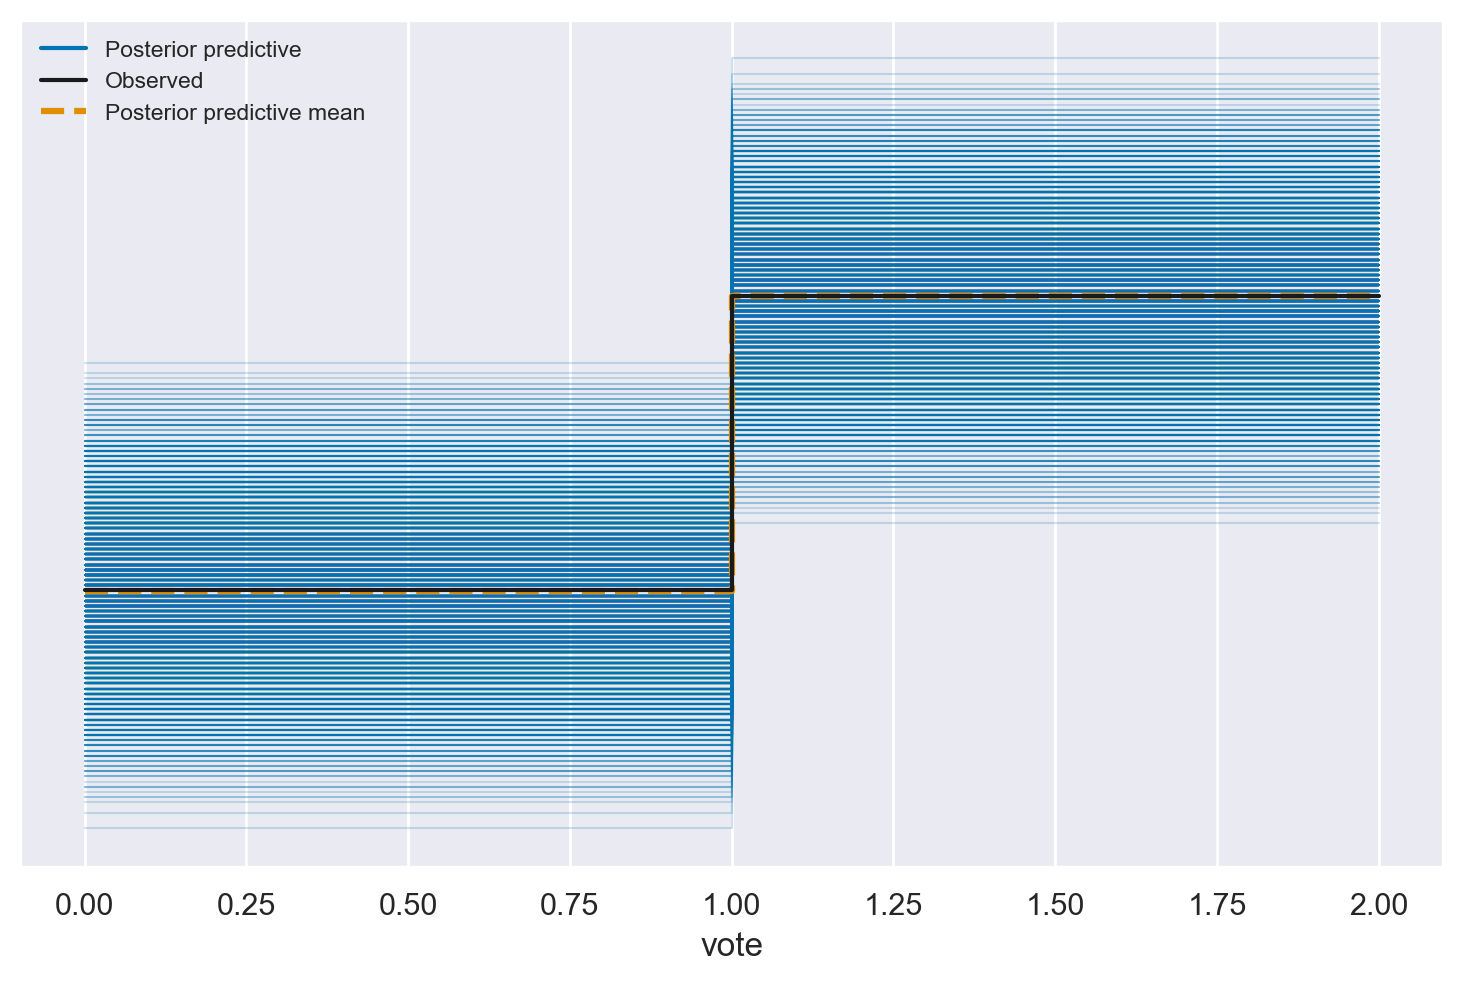

In [12]:
az.plot_ppc(clinton_fitted)
plt.show()

In [13]:
loo = az.loo(clinton_fitted, pointwise=True)

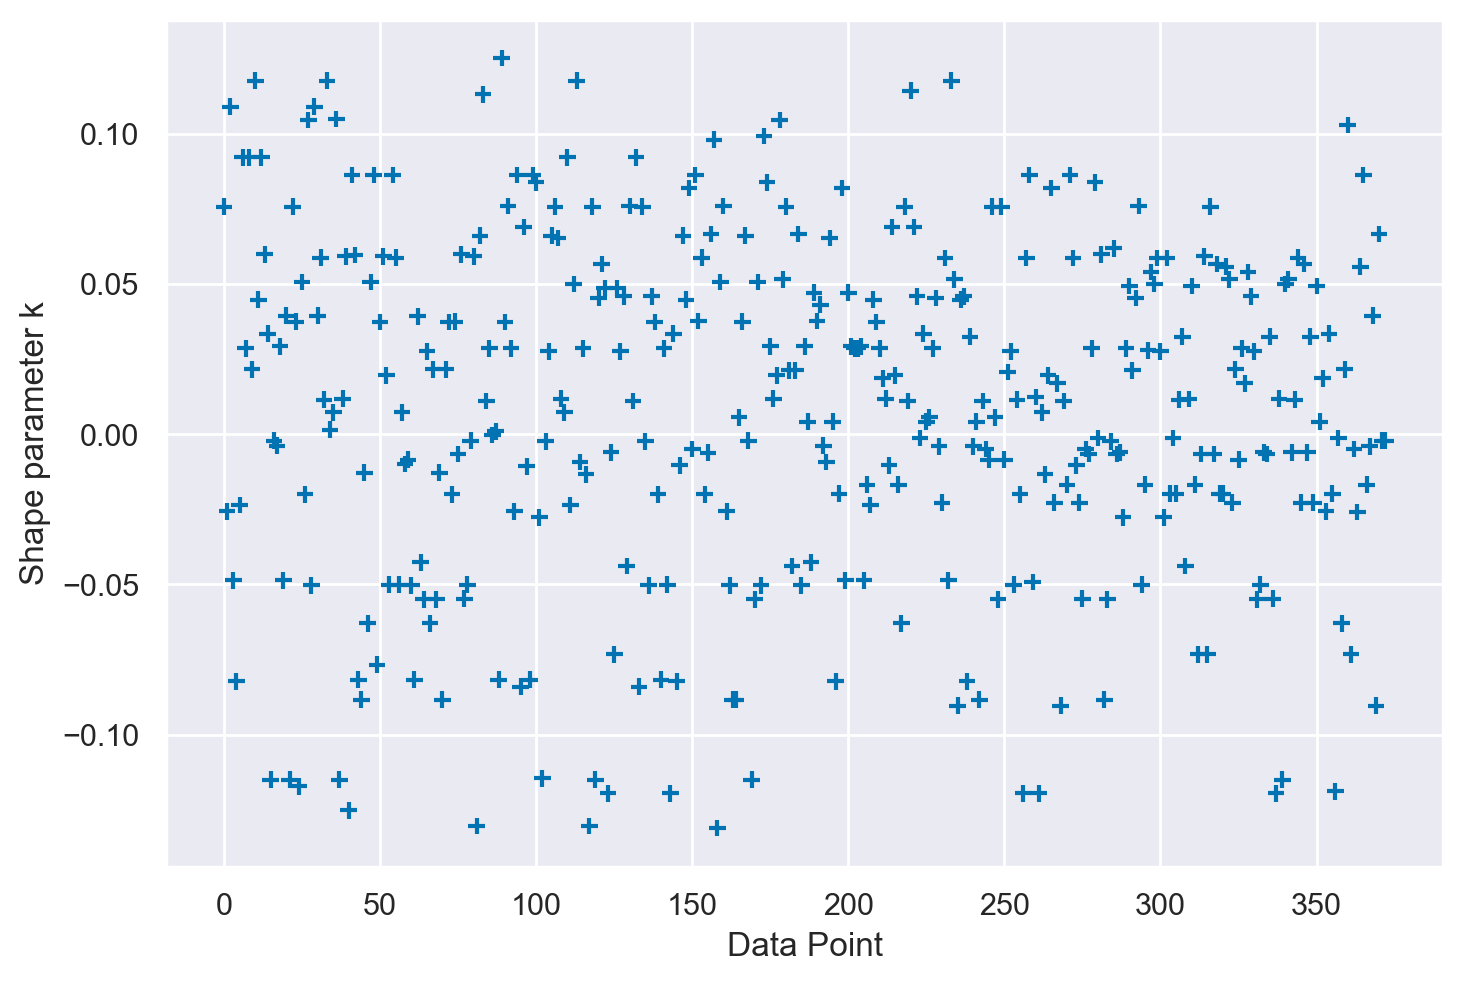

In [14]:
az.plot_khat(loo.pareto_k)
plt.show()

In [15]:
summary_df = az.summary(clinton_fitted)
print(summary_df)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       1.196  0.327   0.550    1.802      0.005    0.004    3860.0   
age            -0.018  0.006  -0.029   -0.006      0.000    0.000    4076.0   
vote_mean[0]    0.549  0.028   0.497    0.601      0.000    0.000    3473.0   
vote_mean[1]    0.509  0.036   0.442    0.573      0.001    0.000    3775.0   
vote_mean[2]    0.443  0.053   0.352    0.549      0.001    0.001    4016.0   
...               ...    ...     ...      ...        ...      ...       ...   
vote_mean[368]  0.605  0.027   0.553    0.653      0.000    0.000    3272.0   
vote_mean[369]  0.592  0.026   0.544    0.640      0.000    0.000    3253.0   
vote_mean[370]  0.513  0.035   0.450    0.576      0.001    0.000    3745.0   
vote_mean[371]  0.622  0.029   0.565    0.675      0.001    0.000    3334.0   
vote_mean[372]  0.622  0.029   0.565    0.675      0.001    0.000    3334.0   

                ess_tail  r_hat  
Intercept        

In [16]:
beta_0 = summary_df.loc['Intercept', 'mean']
print(beta_0)

1.196


In [17]:
np.exp(beta_0)

3.306862980601789

In [18]:
np.exp(beta_0) / (1 + np.exp(beta_0))

0.76781244156036

In [19]:
beta_1 = summary_df.loc['age', 'mean']
print(beta_1)

-0.018


In [20]:
np.exp(beta_1)

0.9821610323583008

In [21]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [22]:
clinton_model.predict(clinton_fitted, data=new_data)

In [23]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

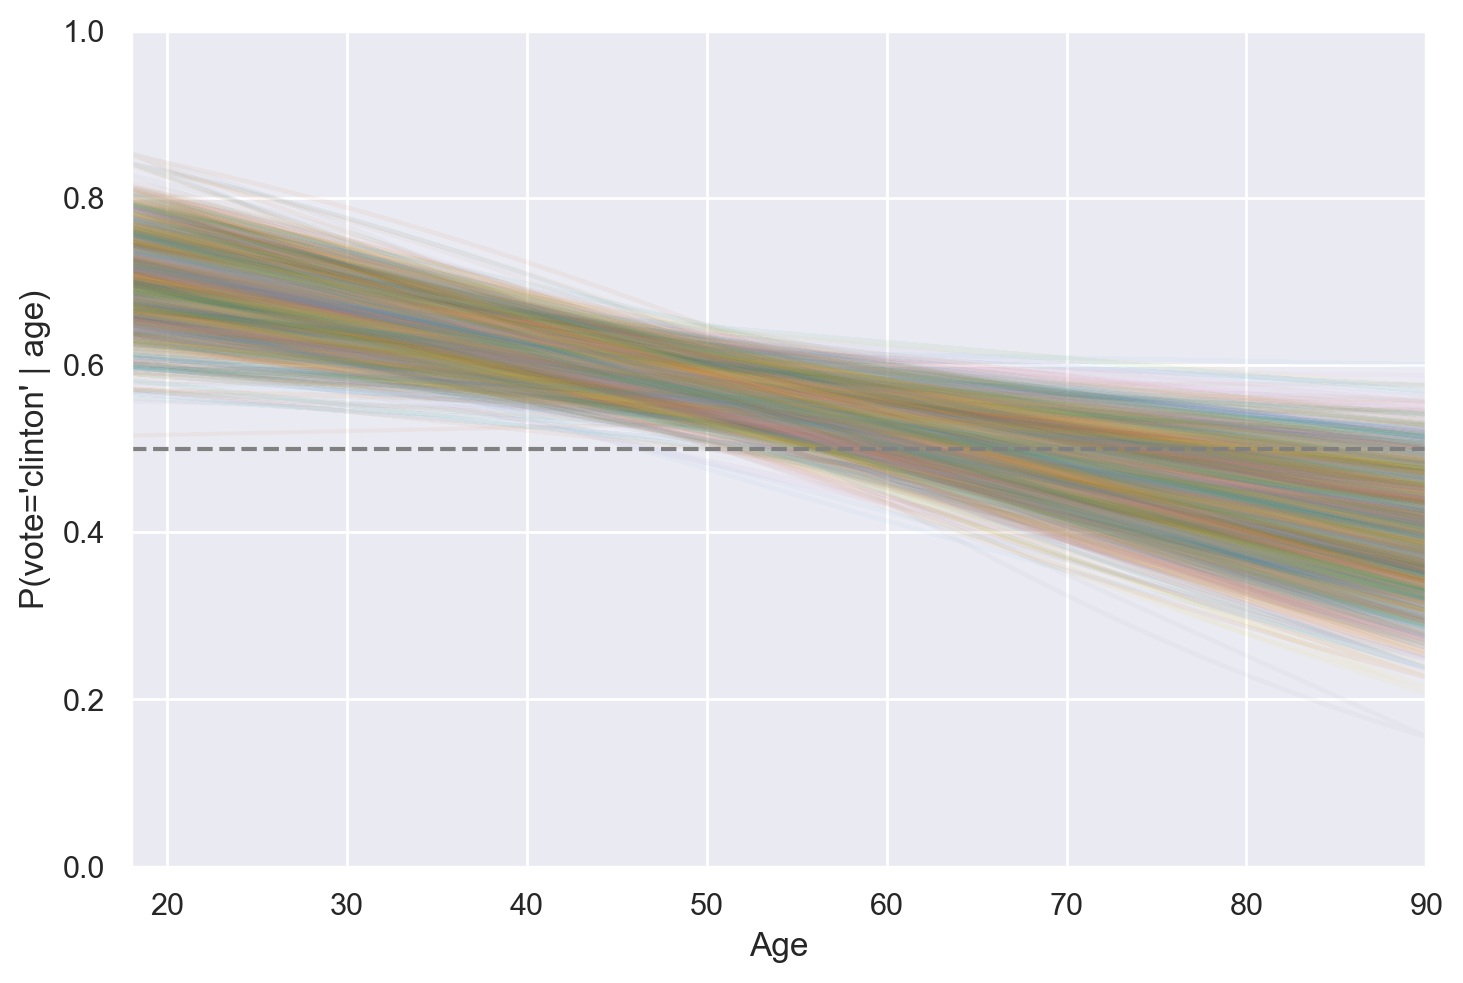

In [24]:
plt.plot(new_data.age, vote_posterior, alpha=0.05)

# Adding a dashed horizontal line at y=0.5 (50% probability)
plt.axhline(y=0.5, color="gray", linestyle="dashed")

plt.ylabel("P(vote='clinton' | age)")
plt.xlabel("Age")
plt.ylim(0, 1)
plt.xlim(18, 90);

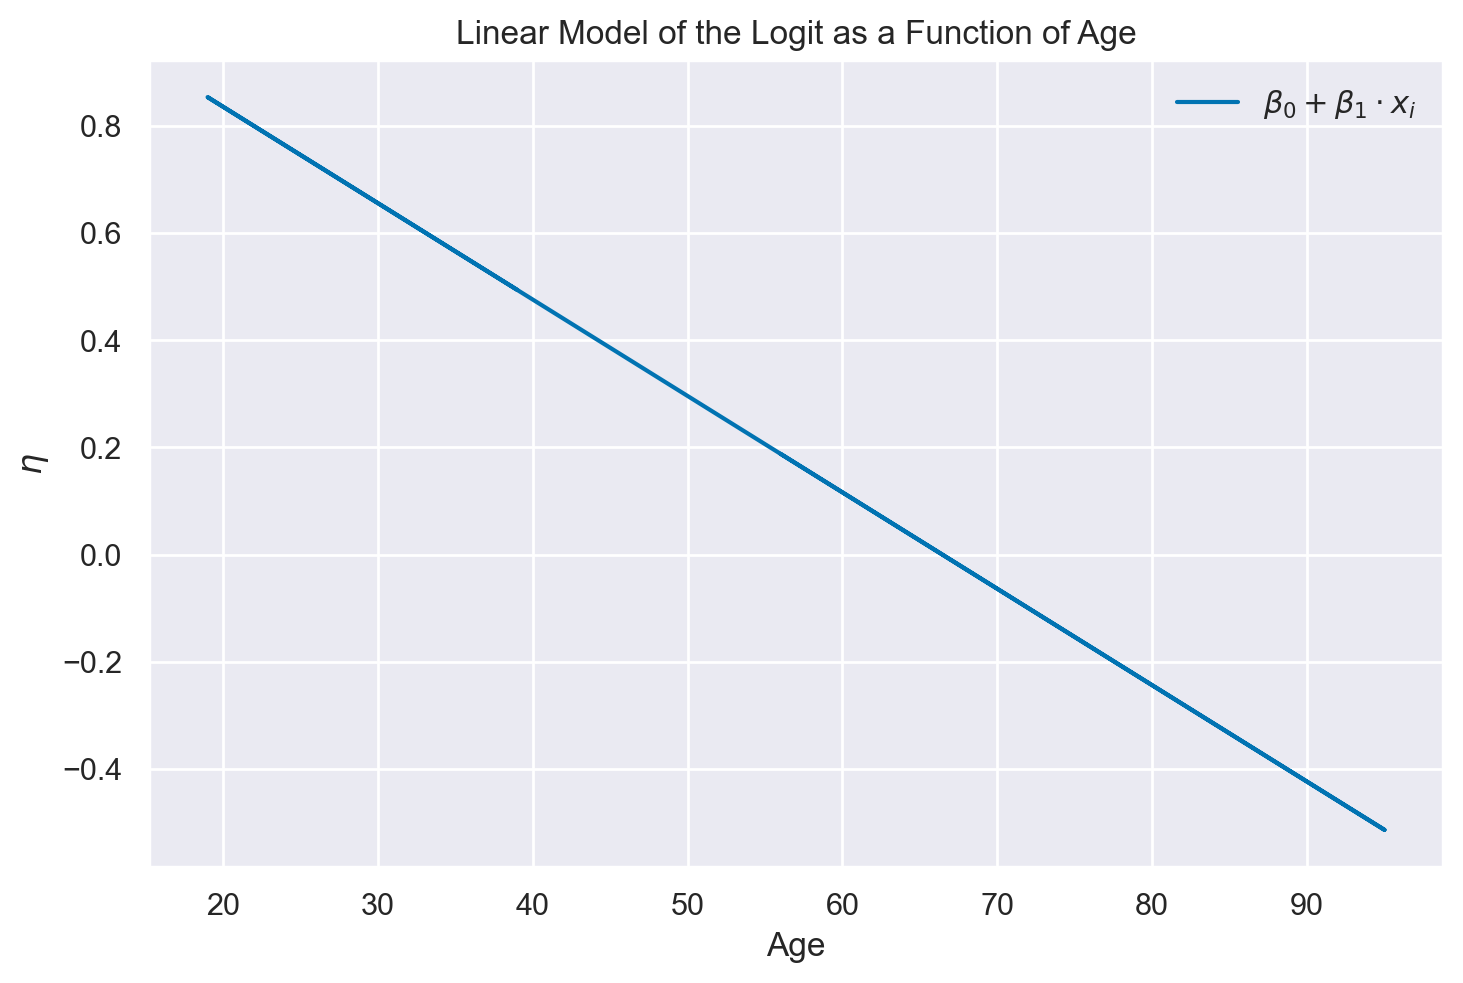

In [25]:
eta = beta_0 + beta_1 * clinton_data["age"]

plt.figure()
plt.plot(clinton_data["age"], eta, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("Age")  # Label for the x-axis
plt.ylabel(r"$\eta$")  # Label for the y-axis
plt.title("Linear Model of the Logit as a Function of Age")  # Title for the plot
plt.legend()
plt.show()

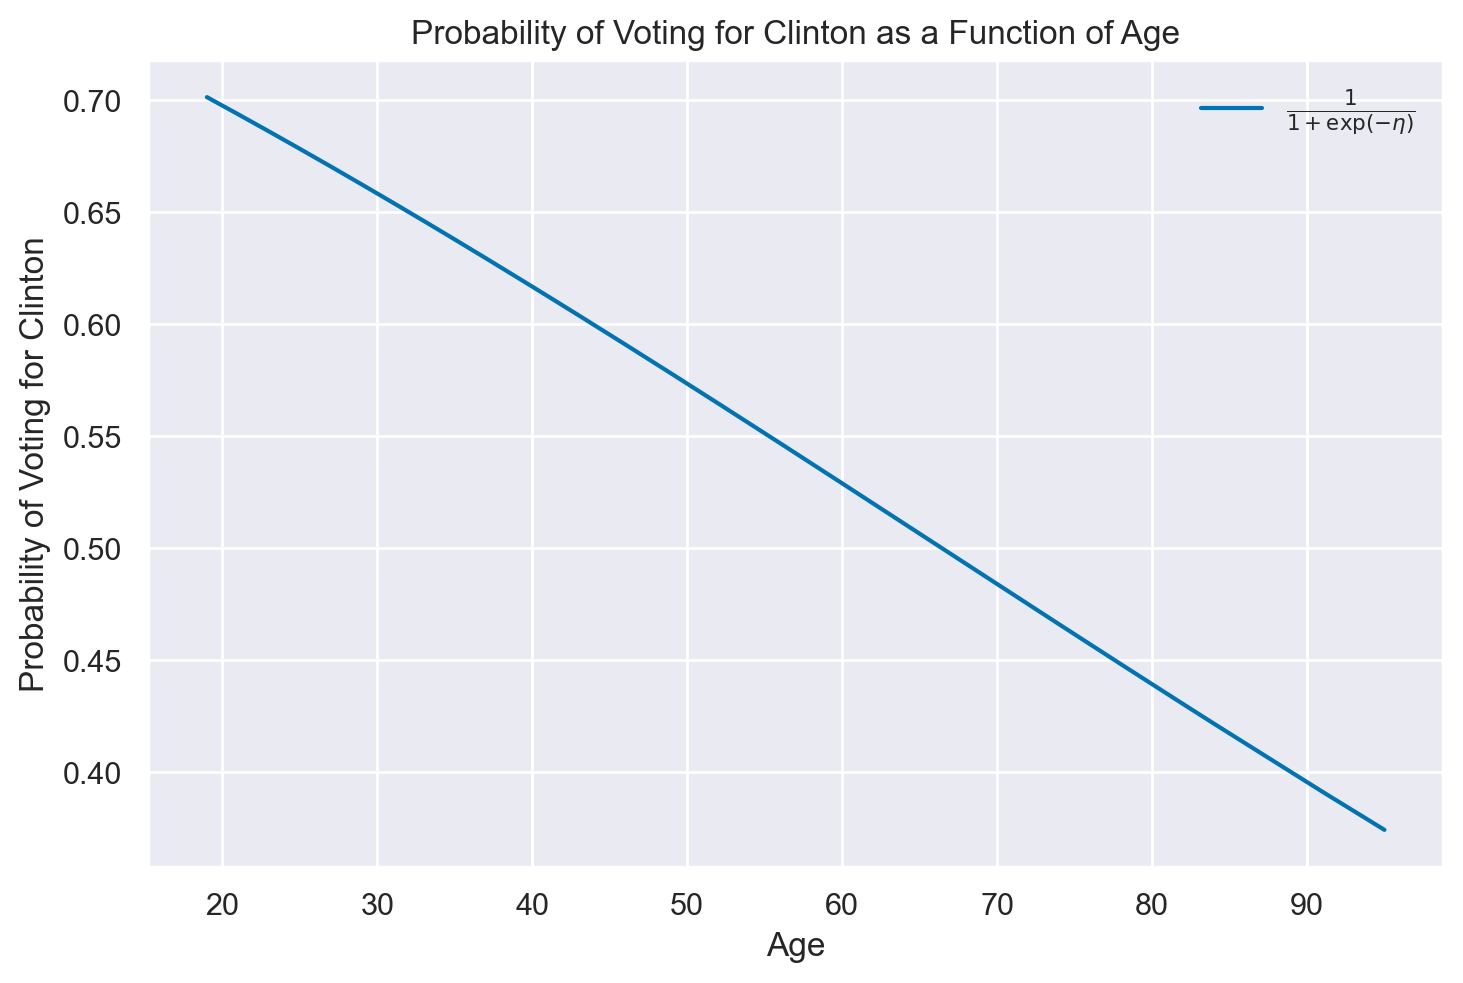

In [26]:
# Sort the age data first
sorted_age = np.sort(clinton_data["age"])

# Calculate eta using the sorted ages
eta_sorted = beta_0 + beta_1 * sorted_age

# Compute the sigmoid function
p_true_sorted = 1 / (1 + np.exp(-eta_sorted))

# Now, plot the sigmoid curve
plt.figure()
plt.plot(sorted_age, p_true_sorted, label=r"$\frac{1}{1 + \exp(-\eta)}$")
plt.xlabel("Age")
plt.ylabel(r"Probability of Voting for Clinton")  
plt.title("Probability of Voting for Clinton as a Function of Age")
plt.legend()
plt.show()

In [27]:
clinton_model.predict(clinton_fitted)

In [28]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.5726193 , 0.54441392, 0.49685601, ..., 0.54756537,
         0.62449559, 0.62449559],
        [0.54007405, 0.50319479, 0.44185023, ..., 0.50730158,
         0.60824344, 0.60824344],
        [0.54803917, 0.49494582, 0.40729352, ..., 0.50086144,
         0.64451737, 0.64451737],
        ...,
        [0.54814755, 0.51274063, 0.45362074, ..., 0.51668761,
         0.61344528, 0.61344528],
        [0.57895095, 0.54882478, 0.49792048, ..., 0.55219406,
         0.63412219, 0.63412219],
        [0.54937996, 0.50985945, 0.44396261, ..., 0.51426583,
         0.62198349, 0.62198349]],

       [[0.5549767 , 0.50764754, 0.42888078, ..., 0.51292878,
         0.64108565, 0.64108565],
        [0.53300362, 0.46135487, 0.34674385, ..., 0.46929124,
         0.66250992, 0.66250992],
        [0.54306323, 0.48248071, 0.38349255, ..., 0.48921927,
         0.65277911, 0.65277911],
...
        [0.54925896, 0.50810947, 0.43955871, ...

In [29]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

,vote,age,party_id,probs
0,clinton,56,democrat,0.548727
1,trump,65,republican,0.508837
2,clinton,80,democrat,0.442878
3,trump,38,republican,0.626053
4,trump,60,republican,0.531032


In [30]:
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);

In [31]:
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

In [32]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 33 125]
 [ 31 184]]


In [33]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

In [34]:
184/ (31+184)

0.8558139534883721

In [35]:
33 / (33+125)

0.2088607594936709

In [36]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T19:02:35.041472+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


